## Overview

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#!unzip  "/gdrive/MyDrive/CaseStudy_HomeCredit/home-credit-default-risk.zip"  -d "/gdrive/MyDrive/CaseStudy_HomeCredit/"

Archive:  /gdrive/MyDrive/CaseStudy_HomeCredit/home-credit-default-risk.zip
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/HomeCredit_columns_description.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/POS_CASH_balance.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/application_test.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/application_train.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/bureau.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/bureau_balance.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/credit_card_balance.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/installments_payments.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/previous_application.csv  
  inflating: /gdrive/MyDrive/CaseStudy_HomeCredit/sample_submission.csv  


<pre>
Serious complication for loan providers(Banking) is to find out the Loan applicants who are very likely to repay the loan.If the loan provider predicted the faithful customer, they will gain more profit and  more imporatanly they will avoid losses.
In kaggle, Home Credit Default Risk is currently using various statistical and machine learning methods to make these predictions, they're challenging. Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

Here we have two classes in the target label, we will conclude this problem as a <strong> Binary classification </strong> problem.

<strong>Problem Statement</strong>
We need to Build the model,which will say by giving the customer information whether this applicant will repay a loan or not
 
<strong>Data Description</strong>
They are 7 different source of table for this problem, combining all the tables is 221 features.
two main tables are <strong>application_train.csv</strong> and <strong>application_test.csv</strong>, which contain the current applications of the clients who have applied for loan. All the other tables are referenced with this table using the unique ID, i.e. SK_ID_CURR.
For more information, visit - https://www.kaggle.com/c/home-credit-default-risk/data

</pre>

In [11]:
# Import all required package for this problem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import iplot
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore') 
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer as Imputer
from tqdm import tqdm

import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve


### Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data

#### Load Data from given CSV

In [10]:
# Select the directory 
os.chdir('/gdrive/My Drive/CaseStudy_HomeCredit')

### Missing values

<pre>
Missing values in a Dataset will affect model performances, to avoid that need to handle this problem for that we have various method , important method is <strong>Imputer</strong> for that first we need to check missing values deatils in all tables.

</pre>

In [5]:
def missing_value(dataframe = 'df', df_name ='TRAIN', visualizse = True, head_count = 5):
    '''
    dataframe - Pass the dataframe to the find missing value of each row.
    df_name  -  Dataframe name
    Visualizse - Boolean, True- Visalizse or False - skip the visualizse part
    head_count - print top five missing column in descending column.
    '''
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(head_count))
    
    if visualizse:
        # visualizse
        figure(figsize=(50,50), facecolor='w', edgecolor='r')
        '''
        edge color - Border color
        dpi - dots-per-inch
        '''
        if len(missing_data.index) >20 :
            sns.set(font_scale = 3)
            sns.barplot(y= missing_data.index, x= missing_data['Percent'])
        else: 
            sns.set(font_scale = 6)
            sns.barplot(y= missing_data.index, x= missing_data['Percent'])
        plt.tight_layout()
        plt.title(str(df_name))
        plt.show()


# <font color='green'> FEATURE ENGINEERING </font>

![image.png](attachment:image.png)

<pre>
From the Exploratory Data Analysis(EDA) we understand the Insight of all tables, major role of feature engineering is selecting best column , best feature selection gives better model. suppose if we have noisy data, model wont give better result. if feature is having missing value either we remove or feature engineering, feature engineering is best because removing noisy features which leads to lack of data.

</pre>

# Reduce memory usage

<pre>

We handling 7 tables, System required a lot of memory intensive computation or data-set size that was large enough to hang my system. so to avoid memory usage problem we going to change the datatype eg - Object to Category, int64 to int32,16,8 deponds on limit of numeric column

</pre>

In [6]:
def reduce_mem_usage(data, verbose = True):
    # refer - https://medium.com/@aakashgoel12/avoid-memory-error-techniques-to-reduce-dataframe-memory-usage-fcf53b2318a2
    #refer: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

# Read all the tables 

In [6]:
# Read all madatory files for this task
def read_mandatory_files():
    df = pd.read_csv('application_train.csv')
    df = reduce_mem_usage(df)
    df_test = pd.read_csv('application_test.csv')
    df_test = reduce_mem_usage(df_test)
    df_bureau = pd.read_csv('bureau.csv')
    df_bureau = reduce_mem_usage(df_bureau)
    df_bureau_bal = pd.read_csv('bureau_balance.csv')
    df_bureau_bal = reduce_mem_usage(df_bureau_bal)
    df_prev_app = pd.read_csv('previous_application.csv')
    df_prev_app = reduce_mem_usage(df_prev_app)
    df_pos = pd.read_csv('POS_CASH_balance.csv')
    df_pos = reduce_mem_usage(df_pos)
    df_credit_bal = pd.read_csv('credit_card_balance.csv')
    df_credit_bal = reduce_mem_usage(df_credit_bal)
    df_inst_pay = pd.read_csv('installments_payments.csv')
    df_inst_pay = reduce_mem_usage(df_inst_pay)
    
    return df, df_test, df_bureau,df_bureau_bal,df_prev_app,df_pos, df_credit_bal,df_inst_pay

# Data Cleaning
<pre>
Erroness value in application train and application test tables, to handling we using below function

</pre>

In [7]:
# Data Cleaning and preprocessing for train and test
def data_cleaning(df='dataframe'):
    df['DAYS_BIRTH'] = round(df['DAYS_BIRTH'] *-1/ 365)

    # abs - convert all value in to postive
    df['DAYS_EMPLOYED']  = abs(df['DAYS_EMPLOYED'])
    df['DAYS_EMPLOYED'].head(2)

    # Replace the anomalous values(Errorness value) with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})

    # Convert days in to years
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] /365
    
    # Create an anomalous flag column
    df['Year_Empolyed_ANOM'] = df["DAYS_EMPLOYED"] == 365243

    #Invalid Gender code, we have limited entry so we removing
    df = df[df['CODE_GENDER'] != 'XNA']

    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    df.loc[df['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan
    
    return df

# Replcaing missing value category with XNS (Unknow)

In [8]:
# replacing Null with XNS -  Unknow category
def replacing_missing_category(df = 'dataframe'):
    # replacing Null with XNS -  Unknow category
    categorical_columns_train = df.dtypes[df.dtypes == 'object'].index.tolist()
    df[categorical_columns_train] = df[categorical_columns_train].fillna('XNA')
    
    # From EDA REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY have discret value, 
    #so we changing this column data type from Int to Object
    
    df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].astype('object')
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].astype('object')
    
    return df

# OneHotEncoding and Label encoder

In [9]:
## Converting Category in to Numerical representation using Onehot encoder and label encoder
'''
OneHotEncoder -  handle_unknown='ignore'
    unknown category is encountered during
    transform, the resulting one-hot encoded columns for this feature
    will be all zeros.
'''
def category_to_numeric(df = 'dataframe',df_test = 'dataframe2'):
    print('Shape of application train before Encoding ', df.shape)
    print('Shape of application test before Encoding ', df_test.shape)
    cat_df = df.dtypes[df.dtypes == 'object'].index.tolist()
    enc = OneHotEncoder(handle_unknown='ignore')
    for i in tqdm(cat_df):

        enc_df = pd.DataFrame(enc.fit_transform(df[[i]]).toarray().astype('int'),columns=enc.get_feature_names([i]))
        enc_df_test = pd.DataFrame(enc.transform(df_test[[i]]).toarray().astype('int'),columns=enc.get_feature_names([i]))
        df = df.drop(i,axis=1).join(enc_df)
        df_test = df_test.drop(i,axis=1).join(enc_df_test)

    print('Shape of application train after Encoding ', df.shape)
    print('Shape of application test after Encoding ', df_test.shape)  
    
    return df, df_test

# Replacing missing value - dtype Numeric

In [10]:
# replacing ,missing value with Median
def replacing_missing_numeric(df = 'dataframe', df_test='dataframe2'):
    # Train missing values
    missing_value(df,df_name='TRAIN',visualizse=False,head_count=5)
    # Test missing values
    missing_value(df_test,df_name='TEST',visualizse=False,head_count=10)
    
    ## Fill in missing values

    #Strategy = Median, variances is high so better to use Median
    imputer = Imputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = [0,1])
    train = df.drop(columns = ['TARGET'])
    train_col = train.columns

    imputer.fit(train)
    train = imputer.transform(train)
    test = imputer.transform(df_test)
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)
    new_df_train = pd.DataFrame(train,columns=train_col)
    new_df_train['SK_ID_CURR'] = df['SK_ID_CURR'].values
    new_df_train['TARGET'] = df['TARGET'].values
    
    new_df_test = pd.DataFrame(test,columns=train_col)
    new_df_test['SK_ID_CURR'] = df_test['SK_ID_CURR'].values
    
    print('Missing value_count after Imputation \n')
    missing_value(new_df_train,df_name='TRAIN',visualizse=False,head_count=5)
    # Test missing values
    missing_value(new_df_test,df_name='TEST',visualizse=False,head_count=5)

    print(' Observation : \n 1.Now there is no missing value in Train and test')
    
    
    return new_df_train, new_df_test

# Create new Custom features - application train and test

<pre>

refer - https://www.wellsfargo.com/financial-education/credit-management/five-c/

<strong> <font color = 'blue'>Capacity</font> </strong> : Lenders need to determine whether you can comfortably afford your payments. Your income and employment history are good indicators of your ability to repay outstanding debt. Income amount, stability, and type of income may all be considered. The ratio of your current and any new debt as compared to your before-tax income, known as debt-to-income ratio (DTI), may be evaluated.

<strong> <font color = 'blue'>Collateral</font> </strong>  (when applying for secured loans): Loans, lines of credit, or credit cards you apply for may be secured or unsecured. With a secured product, such as an auto or home equity loan, you pledge something you own as collateral. The value of your collateral will be evaluated, and any existing debt secured by that collateral will be subtracted from the value. The remaining equity will play a factor in the lending decision.

<strong> <font color = 'blue'>Capital</font> </strong>: While your household income is expected to be the primary source of repayment, capital represents the savings, investments, and other assets that can help repay the loan. This can be helpful if you lose your job or experience other setbacks.

<strong> <font color = 'blue'>Conditions</font> </strong>: Lenders may want to know how you plan to use the money and will consider the loan’s purpose, such as whether the loan will be used to purchase a vehicle or other property. Other factors, such as environmental and economic conditions, may also be considered.
</pre>

In [11]:
def create_custom_features_main_table(df='dataframe1', df_test='dataframe2'):
    ################ Application_ train.csv ###########
    # Flag to represent when Total income is greater than Credit
    df['INCOME_GT_CREDIT_FLAG'] = df['AMT_INCOME_TOTAL'] > df['AMT_CREDIT']

    # Column to represent Credit Income Percent
    df['DIR'] = df['AMT_CREDIT']/(df['AMT_INCOME_TOTAL']+1)

    # Column to represent Annuity Income percent
    df['AIR'] = df['AMT_ANNUITY']/(df['AMT_INCOME_TOTAL']+1)

    # Column to represent Credit Term
    df['ACR'] = (df['AMT_CREDIT']/(df['AMT_ANNUITY']+1))
    

    # Column to represent Days Employed percent in his life
    df['DAR'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH']

    ################ Application_ test.csv ###########

    df_test['INCOME_GT_CREDIT_FLAG'] = df_test['AMT_INCOME_TOTAL'] > df_test['AMT_CREDIT']
    df_test['DIR'] = df_test['AMT_CREDIT']/(df_test['AMT_INCOME_TOTAL']+ 1)
    df_test['AIR'] = df_test['AMT_ANNUITY']/(df_test['AMT_INCOME_TOTAL'] +1)
    df_test['ACR'] = df_test['AMT_CREDIT']/(df_test['AMT_CREDIT']+1)
    df_test['DAR'] = df_test['DAYS_EMPLOYED']/df_test['DAYS_BIRTH']
    
    return df, df_test


# Create unique Column

In [12]:
# when merging two table, chance o having same column name in both table, to avoid we settiing new feature name
# Note , pd.Dummies we have prefix attribute, but for numerical field better to use this function
def create_unique_col(table= 'Bureau',data='df', ID ='SK_ID_CURR' ):
    '''
    table - Dataframe name
    data  = Dataframe
    ID    = Foreign key
    return Column name wit prefix table name
    '''
    
    unique_col_bureau = [] 
    for i in data.columns:
        if i != ID:
            col_name = table+str('_')+str(i)
            unique_col_bureau.append(col_name)
        else:
            unique_col_bureau.append(i)
    print('New Column names  - \n'+str(unique_col_bureau))   
    return unique_col_bureau  

# Create Custom feature - Bureau.csv

In [13]:
def create_custom_bureau_feature(df_bureau='bureau_table'):
    # Create a new column , using existing information from Bureau
    # Number of past loans per customer
    past_loan = df_bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'LOAN_COUNT_BUREAU'})
    print('Past loan details',past_loan.shape )


    # Number of type of credit loan type per customer
    credit_type = df_bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'LOAN_TYPES_BUREAU'})
    print('credit_type details',credit_type.shape)


    # total_loan amount still date
    sum_total_count = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_LOAN_AMT_SUM'})
    print('sum_total_count details',sum_total_count.shape )


    # total_loan amount debt still date
    sum_total_count_debt = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT': 'TOTAL_LOAN_AMT_SUM_DEBT'})
    print('sum_total_count_debt details',sum_total_count_debt.shape)


    #merge sum_total_count and sum_total_count_debt
    debt_credit_df  =  sum_total_count.merge(sum_total_count_debt,on='SK_ID_CURR')
    debt_credit_df['debt_credit_ratio'] = debt_credit_df['TOTAL_LOAN_AMT_SUM_DEBT'] / (debt_credit_df['TOTAL_LOAN_AMT_SUM'] +1)
    print('Merge of sum_total_count and sum_total_count_debt',debt_credit_df.shape)


    # Sum of AMT_CREDIT_SUM_OVERDUE
    Total_customer_overdue  = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'SUM_AMT_CREDIT_SUM_OVERDUE'})
    print('Sum of over due amount',Total_customer_overdue.shape)
    # sum AMT_CREDIT_SUM_DEBT
    Total_customer_debt =  df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
    print('Sum of total debt amount ',Total_customer_debt.shape)


    sum_overdue_credit_sum  = Total_customer_overdue.merge(Total_customer_debt,on='SK_ID_CURR')
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum['SUM_AMT_CREDIT_SUM_OVERDUE'] / (sum_overdue_credit_sum['TOTAL_CUSTOMER_DEBT']+1)
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum['overdue_debt_ratio'].fillna(0)
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum.replace([np.inf,-np.inf],0)
    sum_overdue_credit_sum['overdue_debt_ratio'] = pd.to_numeric(sum_overdue_credit_sum['overdue_debt_ratio'],downcast='float')
    print('Ratio of Overdue and credit debt amount',sum_overdue_credit_sum.shape)
    
    df_bureau = df_bureau.merge(past_loan,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(credit_type,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(debt_credit_df,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(sum_overdue_credit_sum,on='SK_ID_CURR',how='left')
    
    return df_bureau



# Join application train and bureau.csv

In [14]:
# Joining application_train and BUREAU.csv
def join_application_bureau(df ='table1', df_bureau = 'table2'):
    # Categorical feature - merging
    # Converting all categorical in to onehot encoding
    categorical_bureau = pd.get_dummies(df_bureau.select_dtypes('object'), prefix='Bureau')
    categorical_bureau['SK_ID_CURR'] = df_bureau['SK_ID_CURR']

    grp_bureau = categorical_bureau.groupby(by = ['SK_ID_CURR']).mean().reset_index()
    print('Column_names_Categorical', grp_bureau.columns)
    
    # Merge train and bureau_categorical
    df_main = df.merge(grp_bureau, on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_bureau.columns].fillna(0))
    
    # Combining Numerical features

    Numerical_bureau_col = df_bureau.select_dtypes(include=[np.number]).columns
    Numerical_bureau = df_bureau[Numerical_bureau_col]


    grp_bureau_num = Numerical_bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    print('Column_names_Numeric', grp_bureau_num.columns)

    #There may be some column name for both application and bureau.csv, inorder to avoid we giving unique column name
    grp_bureau_num.columns = create_unique_col(table='Bureau',data=grp_bureau_num,ID='SK_ID_CURR')

    # Merge train and bureau_categorical
    df_main = df_main.merge(grp_bureau_num, on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_bureau_num.columns].fillna(0))
    
    return df_main




# Join application, bureau and bureau_balance

In [15]:
# Joining Bureau_Balance data to merge of Application and Bureau(df_main)

def data_cleaning_bureau_bal(df_bureau_bal= 'dataframe'):
    # C - Close , so we giving weight to 0, remaining incremental, thing is X - Unknow so benefit of doubt we giving middle value(4) 
    status_label_encoding = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
    df_bureau_bal['STATUS'] = df_bureau_bal['STATUS'].map(status_label_encoding)

    # Monthly Balance is in Negative , easy interpreatation we changing to postive
    df_bureau_bal['MONTHS_BALANCE'] = abs(df_bureau_bal['MONTHS_BALANCE'])

    # Creating new features 'Weightage_balance' = divide Status by Months_balance 
    df_bureau_bal['WEIGHT_status'] = df_bureau_bal['STATUS'] / (df_bureau_bal['MONTHS_BALANCE'] +1)
    
    return df_bureau_bal

def merge_application_BureauBal(df_main='dataframe1', df_bureau='dataframe2', df_bureau_bal='dataframe3'):
    df_bureau_bal = data_cleaning_bureau_bal(df_bureau_bal= df_bureau_bal)
    Bureau_merge_Bureau_bal =  df_bureau.merge(df_bureau_bal, on='SK_ID_BUREAU')
    Bureau_merge_Bureau_bal = Bureau_merge_Bureau_bal[['SK_ID_CURR', 'MONTHS_BALANCE','STATUS','WEIGHT_status']].groupby('SK_ID_CURR')['MONTHS_BALANCE','STATUS','WEIGHT_status'].sum().reset_index()
    Bureau_merge_Bureau_bal.columns = create_unique_col(table='Bureau_bal',data=Bureau_merge_Bureau_bal,ID='SK_ID_CURR')
    df_main = df_main.merge(Bureau_merge_Bureau_bal, on='SK_ID_CURR',how='left')
    df_main.update(df_main[['Bureau_bal_MONTHS_BALANCE','Bureau_bal_STATUS','Bureau_bal_WEIGHT_status']].fillna(0))
    print('Shape of main table after merge Application, Bureau and Bureau_balance', df_main.shape)
    
    return df_main

# Join application, bureau ,bureau_balance and previous application

In [16]:
def create_custom_prevapp_feature(previous_application='bureau_table'):
    # Create a new column , using existing information from Previous applications
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
    previous_application['AMT_INTEREST'] = previous_application['CNT_PAYMENT'] * previous_application[
                                            'AMT_ANNUITY'] - previous_application['AMT_CREDIT'] 
    previous_application['INTEREST_SHARE'] = previous_application['AMT_INTEREST'] / (previous_application[
                                                                                            'AMT_CREDIT'] + 0.00001)
    previous_application['INTEREST_RATE'] = 2 * 12 * previous_application['AMT_INTEREST'] / (previous_application[
                                        'AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))
    

    previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']

    previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
    previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']

    previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
    previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)
   
    print('After creating custom feature ', previous_application.shape)
    return previous_application



In [17]:
def merge_application_prev_app(df_main = 'dataframe1',df_prev_app ='dataframe2'):
    Pre_app_count= df_prev_app[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'}).fillna(0)

    # Combining categorical features
    pre_app_categorical = pd.get_dummies(df_prev_app.select_dtypes('object'))
    pre_app_categorical['SK_ID_CURR'] = df_prev_app['SK_ID_CURR']

    grp_PrevApp = pre_app_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_PrevApp.columns = create_unique_col(table='PREV_APP',data=grp_PrevApp,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_PrevApp,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_PrevApp.columns].fillna(0))

    # Combining numerical features
    grp_PrevApp_numeric = df_prev_app.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    grp_PrevApp_numeric.columns = create_unique_col(table='PREV_APP',data=grp_PrevApp_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(grp_PrevApp_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[grp_PrevApp_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance and Previous_Application ', df_main.shape)
    return df_main
    
    

## Join application, bureau ,bureau_balance , previous application and point of sale

In [37]:
def create_custom_pos_feature(pos_cash='dataframe1'):

  #creating new features based on Domain Knowledge
  pos_cash['SK_DPD_RATIO'] = pos_cash['SK_DPD'] / (pos_cash['SK_DPD_DEF'] + 0.00001)
  pos_cash['TOTAL_TERM'] = pos_cash['CNT_INSTALMENT'] + pos_cash['CNT_INSTALMENT_FUTURE']

  print('Shape of POS after feature engineering', pos_cash.shape)

  return pos_cash


In [19]:
def merge_application_pos(df_main = 'dataframe1',df_pos ='dataframe2'):
    Pre_app_count= df_prev_app[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'}).fillna(0)

    POS_count= df_pos[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'POS_COUNT'}).fillna(0)

    # Combining categorical features
    POS_categorical = pd.get_dummies(df_pos.select_dtypes('object'))
    POS_categorical['SK_ID_CURR'] = df_pos['SK_ID_CURR']

    grp_POS = POS_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_POS.columns = create_unique_col(table='POS',data=grp_POS,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_POS,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_POS.columns].fillna(0))

    # Combining numerical features
    POS_numeric = df_pos.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    POS_numeric.columns = create_unique_col(table='POS',data=POS_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(POS_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[POS_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application and POS ', df_main.shape)
    
    return df_main
    
    

### Join application, bureau ,bureau_balance , previous application,POS and Installment payment

In [20]:
def create_custom_Inspay_feature(installments_payments='bureau_table'):
    # Create a new column , using existing information from Install payment applications
    installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 0.00001)
    installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
    installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']

    print('Shape of InstallPayment after feature engineering', installments_payments.shape)

    return installments_payments
   



In [21]:
def merge_application_Inspay(df_main = 'dataframe1',df_inst_pay ='dataframe2'):
    INSPAY_numeric = df_inst_pay.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    INSPAY_numeric.columns = create_unique_col(table='INSTPAY',data=INSPAY_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(INSPAY_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[INSPAY_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay ', df_main.shape)
    return df_main

### Join application, bureau ,bureau_balance , previous application,POS , Installment payment and credit balance

In [22]:
def create_custom_Credit_bal_feature(cc_balance='CCB_table'):

     #Creating new features
        cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + cc_balance['AMT_DRAWINGS_CURRENT'] + cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + cc_balance['AMT_DRAWINGS_POS_CURRENT']
        cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + cc_balance['CNT_DRAWINGS_CURRENT'] + cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + cc_balance['CNT_DRAWINGS_POS_CURRENT'] + cc_balance['CNT_INSTALMENT_MATURE_CUM']
        cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
        cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
        cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] - cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / (cc_balance['SK_DPD_DEF'] + 0.00001)

        print('Shape of Credit Card balance after feature engineering', cc_balance.shape)

        return cc_balance

In [23]:
def merge_application_credit_bal(df_main = 'dataframe1',df_credit_bal ='dataframe2'):
    # Combining categorical features
    CREBAL_categorical = pd.get_dummies(df_credit_bal.select_dtypes('object'))
    CREBAL_categorical['SK_ID_CURR'] = df_credit_bal['SK_ID_CURR']

    grp_CREDBAL = CREBAL_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_CREDBAL.columns = create_unique_col(table='CREDITBAL',data=grp_CREDBAL,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_CREDBAL,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_CREDBAL.columns].fillna(0))

    # Combining numerical features
    CREDBAL_numeric = df_credit_bal.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    CREDBAL_numeric.columns = create_unique_col(table='CREDITBAL',data=CREDBAL_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(CREDBAL_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[CREDBAL_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS, INSTALLMENT PAYMENT and CREDIt BAL ', df_main.shape)
    
    return df_main


In [24]:
df, df_test, df_bureau,df_bureau_bal,df_prev_app,df_pos, df_credit_bal,df_inst_pay = read_mandatory_files()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 286.23 MB
Memory usage after optimization: 92.38 MB
Decreased by 67.7%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 45.00 MB
Memory usage after optimization: 14.60 MB
Decreased by 67.6%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 222.62 MB
Memory usage after optimization: 112.95 MB
Decreased by 49.3%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

In [25]:
# Data Cleaning
df =  data_cleaning(df = df)
df_test =  data_cleaning(df = df_test)

In [26]:
# Handling missing value-  Category
df =  replacing_missing_category(df = df)
df_test =  replacing_missing_category(df = df_test)

In [27]:
# OneHot encoding and Label encoding
df, df_test =  category_to_numeric(df = df, df_test=df_test) 

  0%|          | 0/18 [00:00<?, ?it/s]

Shape of application train before Encoding  (307507, 123)
Shape of application test before Encoding  (48744, 122)


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]

Shape of application train after Encoding  (307507, 256)
Shape of application test after Encoding  (48744, 255)


In [29]:
# create custome features for train and test application
df, df_test = create_custom_features_main_table(df=df, df_test=df_test)
print('Shape of application train ', df.shape)
print('Shape of application test ', df_test.shape)

Shape of application train  (307507, 261)
Shape of application test  (48744, 260)


In [30]:
# Handling missing value-  Category
df ,df_test=  replacing_missing_numeric(df = df,df_test = df_test)


                           Total   Percent
COMMONAREA_MODE           214862  0.698722
COMMONAREA_MEDI           214862  0.698722
COMMONAREA_AVG            214862  0.698722
NONLIVINGAPARTMENTS_AVG   213512  0.694332
NONLIVINGAPARTMENTS_MEDI  213512  0.694332
                          Total   Percent
COMMONAREA_MEDI           33495  0.687161
COMMONAREA_AVG            33495  0.687161
COMMONAREA_MODE           33495  0.687161
NONLIVINGAPARTMENTS_AVG   33347  0.684125
NONLIVINGAPARTMENTS_MEDI  33347  0.684125
NONLIVINGAPARTMENTS_MODE  33347  0.684125
LIVINGAPARTMENTS_AVG      32780  0.672493
LIVINGAPARTMENTS_MODE     32780  0.672493
LIVINGAPARTMENTS_MEDI     32780  0.672493
FLOORSMIN_MODE            32466  0.666051
Training data shape:  (307507, 260)
Testing data shape:  (48744, 260)
Missing value_count after Imputation 

                  Total  Percent
TARGET                0      0.0
FLAG_DOCUMENT_21      0      0.0
FLAG_DOCUMENT_19      0      0.0
FLAG_DOCUMENT_18      0      0.0
FLAG_D

In [31]:
# Bureau table custom features
df_bureau = create_custom_bureau_feature(df_bureau=df_bureau)

Past loan details (305811, 2)
credit_type details (305811, 2)
sum_total_count details (305811, 2)
sum_total_count_debt details (305811, 2)
Merge of sum_total_count and sum_total_count_debt (305811, 4)
Sum of over due amount (305811, 2)
Sum of total debt amount  (305811, 2)
Ratio of Overdue and credit debt amount (305811, 4)


In [32]:
# Join application and bureau table
df_main = join_application_bureau(df = df, df_bureau=df_bureau)

df_main_test = join_application_bureau(df = df_test, df_bureau=df_bureau)

Column_names_Categorical Index(['SK_ID_CURR', 'Bureau_Active', 'Bureau_Bad debt', 'Bureau_Closed',
       'Bureau_Sold', 'Bureau_currency 1', 'Bureau_currency 2',
       'Bureau_currency 3', 'Bureau_currency 4', 'Bureau_Another type of loan',
       'Bureau_Car loan', 'Bureau_Cash loan (non-earmarked)',
       'Bureau_Consumer credit', 'Bureau_Credit card',
       'Bureau_Interbank credit', 'Bureau_Loan for business development',
       'Bureau_Loan for purchase of shares (margin lending)',
       'Bureau_Loan for the purchase of equipment',
       'Bureau_Loan for working capital replenishment', 'Bureau_Microloan',
       'Bureau_Mobile operator loan', 'Bureau_Mortgage',
       'Bureau_Real estate loan', 'Bureau_Unknown type of loan'],
      dtype='object')
Column_names_Numeric Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
     

In [33]:
# Join application, bureau and Bureau_balance
df_main = merge_application_BureauBal(df_main=df_main, df_bureau=df_bureau, df_bureau_bal=df_bureau_bal)

df_main_test = merge_application_BureauBal(df_main=df_main_test, df_bureau=df_bureau, df_bureau_bal=df_bureau_bal)


New Column names  - 
['SK_ID_CURR', 'Bureau_bal_MONTHS_BALANCE', 'Bureau_bal_STATUS', 'Bureau_bal_WEIGHT_status']
Shape of main table after merge Application, Bureau and Bureau_balance (307507, 307)
New Column names  - 
['SK_ID_CURR', 'Bureau_bal_MONTHS_BALANCE', 'Bureau_bal_STATUS', 'Bureau_bal_WEIGHT_status']
Shape of main table after merge Application, Bureau and Bureau_balance (48744, 306)


In [34]:
#Creating custom features for previous applications
df_prev_app = create_custom_prevapp_feature(previous_application=df_prev_app)

After creating custom feature  (1670214, 45)


In [35]:
# Join application, bureau , Bureau_balance and previous application
df_main = merge_application_prev_app(df_main=df_main, df_prev_app=df_prev_app)  

df_main_test = merge_application_prev_app(df_main=df_main_test, df_prev_app=df_prev_app)  


New Column names  - 
['SK_ID_CURR', 'PREV_APP_NAME_CONTRACT_TYPE_Cash loans', 'PREV_APP_NAME_CONTRACT_TYPE_Consumer loans', 'PREV_APP_NAME_CONTRACT_TYPE_Revolving loans', 'PREV_APP_NAME_CONTRACT_TYPE_XNA', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY', 'PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_N', 'PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_Y', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Building a house or an annex', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Business development', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a garage', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a home', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a new car', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a us

In [38]:
# create new feature based on existing column in POS table
df_pos = create_custom_pos_feature(pos_cash=df_pos)

Shape of POS after feature engineering (10001358, 10)


In [39]:
# Join application, bureau , Bureau_balance , previous application and pos
df_main = merge_application_pos(df_main=df_main, df_pos=df_pos)  

df_main_test = merge_application_pos(df_main=df_main_test, df_pos=df_pos)  


New Column names  - 
['SK_ID_CURR', 'POS_NAME_CONTRACT_STATUS_Active', 'POS_NAME_CONTRACT_STATUS_Amortized debt', 'POS_NAME_CONTRACT_STATUS_Approved', 'POS_NAME_CONTRACT_STATUS_Canceled', 'POS_NAME_CONTRACT_STATUS_Completed', 'POS_NAME_CONTRACT_STATUS_Demand', 'POS_NAME_CONTRACT_STATUS_Returned to the store', 'POS_NAME_CONTRACT_STATUS_Signed', 'POS_NAME_CONTRACT_STATUS_XNA']
New Column names  - 
['SK_ID_CURR', 'POS_MONTHS_BALANCE', 'POS_CNT_INSTALMENT', 'POS_CNT_INSTALMENT_FUTURE', 'POS_SK_DPD', 'POS_SK_DPD_DEF', 'POS_SK_DPD_RATIO', 'POS_TOTAL_TERM']
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application and POS  (307507, 493)
New Column names  - 
['SK_ID_CURR', 'POS_NAME_CONTRACT_STATUS_Active', 'POS_NAME_CONTRACT_STATUS_Amortized debt', 'POS_NAME_CONTRACT_STATUS_Approved', 'POS_NAME_CONTRACT_STATUS_Canceled', 'POS_NAME_CONTRACT_STATUS_Completed', 'POS_NAME_CONTRACT_STATUS_Demand', 'POS_NAME_CONTRACT_STATUS_Returned to the store', 'POS_NAME_CONTRACT_STATUS_Signed

In [40]:
#Creating custom features - Install payment features
df_inst_pay  = create_custom_Inspay_feature(installments_payments=df_inst_pay)

Shape of InstallPayment after feature engineering (13605401, 12)


In [41]:
# Join application, bureau , Bureau_balance , previous application , pos and Installment payment
df_main = merge_application_Inspay(df_main=df_main, df_inst_pay=df_inst_pay) 

df_main_test = merge_application_Inspay(df_main=df_main_test, df_inst_pay=df_inst_pay)  

New Column names  - 
['SK_ID_CURR', 'INSTPAY_NUM_INSTALMENT_VERSION', 'INSTPAY_NUM_INSTALMENT_NUMBER', 'INSTPAY_DAYS_INSTALMENT', 'INSTPAY_DAYS_ENTRY_PAYMENT', 'INSTPAY_AMT_INSTALMENT', 'INSTPAY_AMT_PAYMENT', 'INSTPAY_AMT_PAYMENT_DIFF', 'INSTPAY_AMT_PAYMENT_RATIO', 'INSTPAY_DAYS_PAYMENT_RATIO', 'INSTPAY_DAYS_PAYMENT_DIFF']
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay  (307507, 503)
New Column names  - 
['SK_ID_CURR', 'INSTPAY_NUM_INSTALMENT_VERSION', 'INSTPAY_NUM_INSTALMENT_NUMBER', 'INSTPAY_DAYS_INSTALMENT', 'INSTPAY_DAYS_ENTRY_PAYMENT', 'INSTPAY_AMT_INSTALMENT', 'INSTPAY_AMT_PAYMENT', 'INSTPAY_AMT_PAYMENT_DIFF', 'INSTPAY_AMT_PAYMENT_RATIO', 'INSTPAY_DAYS_PAYMENT_RATIO', 'INSTPAY_DAYS_PAYMENT_DIFF']
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay  (48744, 502)


In [42]:
# Create new feature Creditcard balance
df_credit_bal = create_custom_Credit_bal_feature(cc_balance=df_credit_bal)

Shape of Credit Card balance after feature engineering (3840312, 31)


In [43]:
# Join application, bureau , Bureau_balance , previous application , pos , Installment payment and Credit balance

df_main = merge_application_credit_bal(df_main=df_main, df_credit_bal=df_credit_bal)  

df_main_test = merge_application_credit_bal(df_main=df_main_test, df_credit_bal=df_credit_bal)  

New Column names  - 
['SK_ID_CURR', 'CREDITBAL_NAME_CONTRACT_STATUS_Active', 'CREDITBAL_NAME_CONTRACT_STATUS_Approved', 'CREDITBAL_NAME_CONTRACT_STATUS_Completed', 'CREDITBAL_NAME_CONTRACT_STATUS_Demand', 'CREDITBAL_NAME_CONTRACT_STATUS_Refused', 'CREDITBAL_NAME_CONTRACT_STATUS_Sent proposal', 'CREDITBAL_NAME_CONTRACT_STATUS_Signed']
New Column names  - 
['SK_ID_CURR', 'CREDITBAL_MONTHS_BALANCE', 'CREDITBAL_AMT_BALANCE', 'CREDITBAL_AMT_CREDIT_LIMIT_ACTUAL', 'CREDITBAL_AMT_DRAWINGS_ATM_CURRENT', 'CREDITBAL_AMT_DRAWINGS_CURRENT', 'CREDITBAL_AMT_DRAWINGS_OTHER_CURRENT', 'CREDITBAL_AMT_DRAWINGS_POS_CURRENT', 'CREDITBAL_AMT_INST_MIN_REGULARITY', 'CREDITBAL_AMT_PAYMENT_CURRENT', 'CREDITBAL_AMT_PAYMENT_TOTAL_CURRENT', 'CREDITBAL_AMT_RECEIVABLE_PRINCIPAL', 'CREDITBAL_AMT_RECIVABLE', 'CREDITBAL_AMT_TOTAL_RECEIVABLE', 'CREDITBAL_CNT_DRAWINGS_ATM_CURRENT', 'CREDITBAL_CNT_DRAWINGS_CURRENT', 'CREDITBAL_CNT_DRAWINGS_OTHER_CURRENT', 'CREDITBAL_CNT_DRAWINGS_POS_CURRENT', 'CREDITBAL_CNT_INSTALMENT_MATU

In [44]:
df_main.shape

(307507, 538)

In [45]:
df_main.head(3)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,...,INSTPAY_AMT_PAYMENT,INSTPAY_AMT_PAYMENT_DIFF,INSTPAY_AMT_PAYMENT_RATIO,INSTPAY_DAYS_PAYMENT_RATIO,INSTPAY_DAYS_PAYMENT_DIFF,CREDITBAL_NAME_CONTRACT_STATUS_Active,CREDITBAL_NAME_CONTRACT_STATUS_Approved,CREDITBAL_NAME_CONTRACT_STATUS_Completed,CREDITBAL_NAME_CONTRACT_STATUS_Demand,CREDITBAL_NAME_CONTRACT_STATUS_Refused,CREDITBAL_NAME_CONTRACT_STATUS_Sent proposal,CREDITBAL_NAME_CONTRACT_STATUS_Signed,CREDITBAL_MONTHS_BALANCE,CREDITBAL_AMT_BALANCE,CREDITBAL_AMT_CREDIT_LIMIT_ACTUAL,CREDITBAL_AMT_DRAWINGS_ATM_CURRENT,CREDITBAL_AMT_DRAWINGS_CURRENT,CREDITBAL_AMT_DRAWINGS_OTHER_CURRENT,CREDITBAL_AMT_DRAWINGS_POS_CURRENT,CREDITBAL_AMT_INST_MIN_REGULARITY,CREDITBAL_AMT_PAYMENT_CURRENT,CREDITBAL_AMT_PAYMENT_TOTAL_CURRENT,CREDITBAL_AMT_RECEIVABLE_PRINCIPAL,CREDITBAL_AMT_RECIVABLE,CREDITBAL_AMT_TOTAL_RECEIVABLE,CREDITBAL_CNT_DRAWINGS_ATM_CURRENT,CREDITBAL_CNT_DRAWINGS_CURRENT,CREDITBAL_CNT_DRAWINGS_OTHER_CURRENT,CREDITBAL_CNT_DRAWINGS_POS_CURRENT,CREDITBAL_CNT_INSTALMENT_MATURE_CUM,CREDITBAL_SK_DPD,CREDITBAL_SK_DPD_DEF,CREDITBAL_AMT_DRAWING_SUM,CREDITBAL_BALANCE_LIMIT_RATIO,CREDITBAL_CNT_DRAWING_SUM,CREDITBAL_MIN_PAYMENT_RATIO,CREDITBAL_PAYMENT_MIN_DIFF,CREDITBAL_MIN_PAYMENT_TOTAL_RATIO,CREDITBAL_AMT_INTEREST_RECEIVABLE,CREDITBAL_SK_DPD_RATIO
0,100002,0.0,0.001512,0.090287,0.090032,0.077441,0.256286,0.104167,0.035563,0.852140,0.705433,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072173,0.307539,0.155089,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,...,11559.247070,0.0,1.0,0.901367,20.421875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.002089,0.311736,0.132924,0.271605,0.045030,0.520833,0.066324,0.951929,0.959566,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312883,0.727584,0.597038,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,...,64754.585938,0.0,1.0,0.992676,7.199219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.000358,0.022472,0.020025,0.023569,0.134904,0.645833,0.012561,0.827335,0.648326,0.285714,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.518065,0.650485,0.814059,0.087585,0.076294,0.981445,0.755371,0.021103,0.000000,0.137939,0.166748,0.208252,0.048096,0.075623,...,7096.154785,0.0,1.0,0.990234,7.667969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Notes

I have completed Data cleaning , feature engineering totally we have 515 features, but still we can create more features so please suggest some blog which related to this domain or any suggestion to create more features.

kindly review the steps which i followed if any concrens please let me know.

In [ ]:
df_main.to_csv('Home_credit_final.csv', index=False)

In [47]:
df_main_test.to_csv('Home_credit_test_final.csv', index=False)

## Dividing final data into train, valid and test datasets:

In [6]:
df_main = pd.read_csv('Home_credit_final.csv')
df_main_test = pd.read_csv('Home_credit_test_final.csv')

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X =  df_main.drop('TARGET',axis=1)
y =  df_main['TARGET']


X_train, X_test,y_train,y_test  = train_test_split(X.drop('SK_ID_CURR',axis=1), y, test_size =0.3, random_state=123, stratify =y)  

# Cross validation
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify = y_test, test_size=0.5, random_state=123)

print('Shape of X_train ', X_train.shape)
#print('Shape validation CV',X_val.shape)
print('Shape of test ',X_test.shape)
print('Shape of y_train ', y_train.shape)
#print('Shape of y_test_CV ', y_val.shape)
print('Shape of y_test ', y_test.shape)

Shape of X_train  (215254, 536)
Shape of test  (92253, 536)
Shape of y_train  (215254,)
Shape of y_test  (92253,)


In [ ]:
'''# Saving the Dataframes into CSV files for future use
X_train.to_csv('X_train_final.csv')
X_val.to_csv('X_val_final.csv')
X_test.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)'''

In [9]:
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,precision_score,recall_score,f1_score

In [11]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.15, random_state = 33)
model_sk.fit(train_features, train_y, early_stopping_rounds=200, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.591696	valid_0's auc: 0.751968
[400]	valid_0's binary_logloss: 0.565448	valid_0's auc: 0.764086
[600]	valid_0's binary_logloss: 0.551775	valid_0's auc: 0.768869
[800]	valid_0's binary_logloss: 0.542276	valid_0's auc: 0.771371
[1000]	valid_0's binary_logloss: 0.534844	valid_0's auc: 0.772763
[1200]	valid_0's binary_logloss: 0.528458	valid_0's auc: 0.7734
[1400]	valid_0's binary_logloss: 0.522501	valid_0's auc: 0.773786
[1600]	valid_0's binary_logloss: 0.517107	valid_0's auc: 0.773824
[1800]	valid_0's binary_logloss: 0.512041	valid_0's auc: 0.774014
Early stopping, best iteration is:
[1788]	valid_0's binary_logloss: 0.512319	valid_0's auc: 0.774058


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.01, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [13]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))

The no. of features selected: 215


In [21]:
#Reading the best picture using pickle file
import pickle

infile = open('select_features.txt','rb')
selected_features = pickle.load(infile)  

<Figure size 360x144 with 0 Axes>

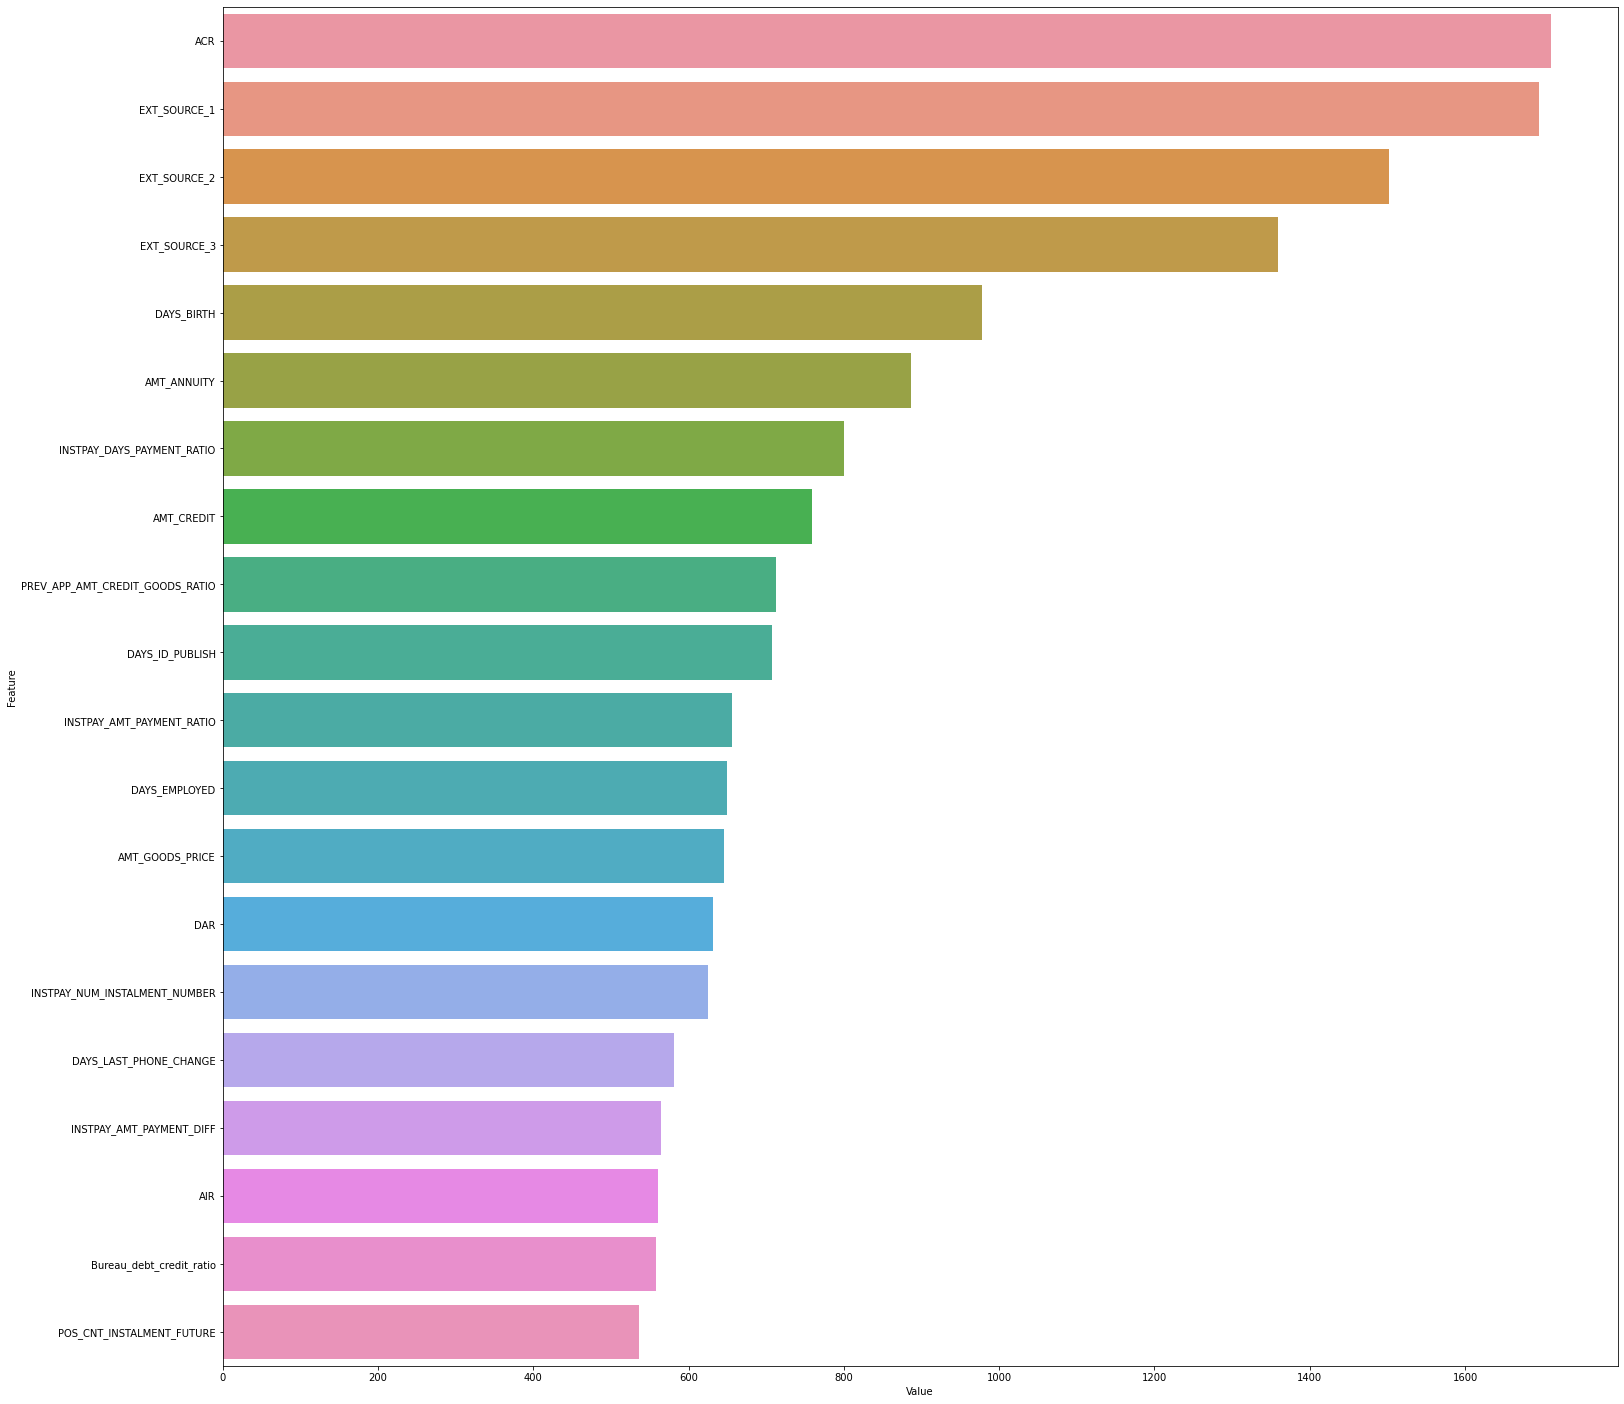

In [14]:
# Plotting Feature Importances 
plt.figure(figsize=(5,2))
figure(figsize=(25,25), facecolor='w', edgecolor='r')
plot_feature_importances = features_df[:20]
sns.barplot(y= plot_feature_importances['Feature'], x= plot_feature_importances['Value'])

##                                                          **MACHINE LEARNING MODEL**




In [22]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("seagreen")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="g", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()


def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

RANDOM MODEL

This would be a baseline model, and that our any sensible model should not perform worse than this.

Training Dataset Results:
	ROC-AUC Score = 0.499163529654763
	Precision Score = 0.08032952846223147
	Recall Score = 0.49772688035909535
	F1_Score  = 0.13833309342162084


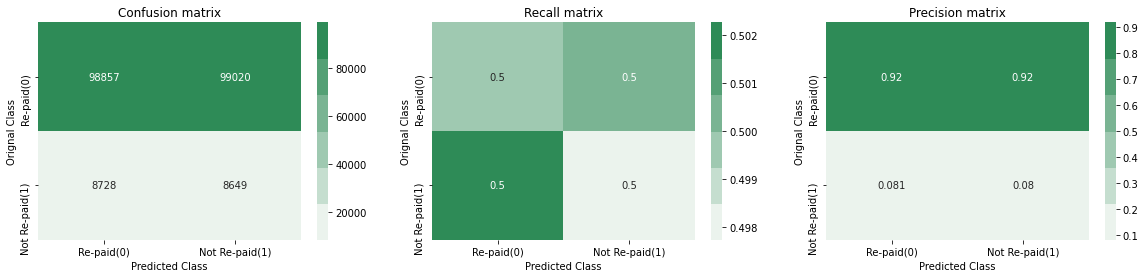

Test Dataset Results:
	ROC-AUC Score = 0.4970628406951919
	Precision Score = 0.08003630156226366
	Recall Score = 0.49731471535982813
	F1_Score  = 0.13788225659351908


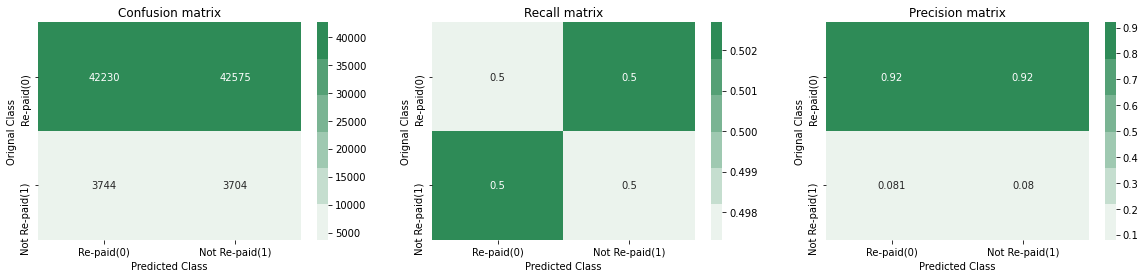

In [35]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(X_train))
predicted_proba_test = np.random.uniform(0, 1, len(X_test))

print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(y_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(y_train, np.round(predicted_proba_train))}")
print(f"\tF1_Score  = {f1_score(y_train, np.round(predicted_proba_train))}")
plot_confusion_matrix(y_train, np.round(predicted_proba_train))
print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_test, predicted_proba_test)}")
print(f"\tPrecision Score = {precision_score(y_test, np.round(predicted_proba_test))}")
print(f"\tRecall Score = {recall_score(y_test, np.round(predicted_proba_test))}")
print(f"\tF1_Score  = {f1_score(y_test, np.round(predicted_proba_test))}")
plot_confusion_matrix(y_test, np.round(predicted_proba_test))


**OBSERVATION**


The AUC for the random model on training dataset comes out to be close to 0.5, and the F1-Score is 0.14, similary for test score is around 0.14 so we going to set this baseline metrics for our future models*

# <pre> <font color ='green'> **DOMINANT MODEL** </font>

we will predict everything as the dominant Class, which is Class Label 0 in our case here. We will see the metrics for this model too, and again our sensible models need to perform better than this.
<pre>

Training Dataset Results:
	ROC-AUC Score = 0.5015341268756781
	Precision Score = 0.0
	Recall Score = 0.0
	F1_Score  = 0.0


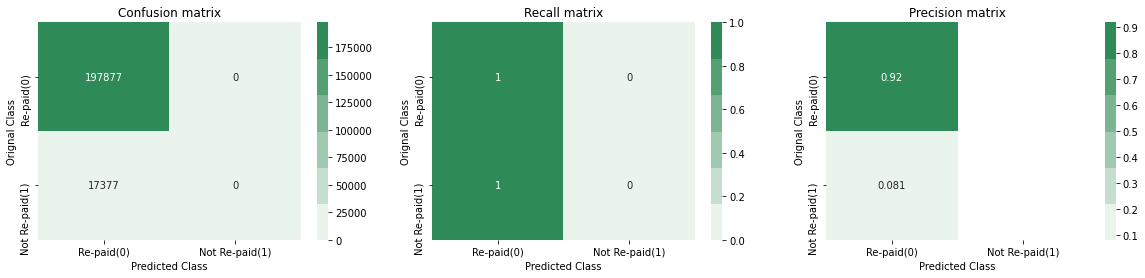

Test Dataset Results:
	ROC-AUC Score = 0.5014119838074218
	Precision Score = 0.0
	Recall Score = 0.0
	F1_Score  = 0.0


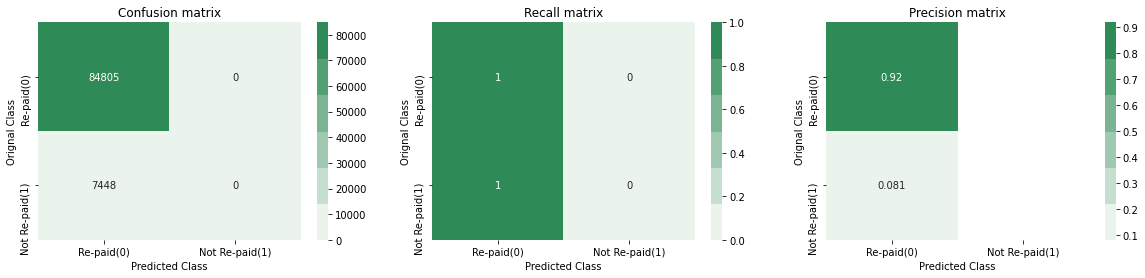

In [36]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 0.5, len(X_train))
predicted_proba_test = np.random.uniform(0, 0.5, len(X_test))

print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(y_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(y_train, np.round(predicted_proba_train))}")
print(f"\tF1_Score  = {f1_score(y_train, np.round(predicted_proba_train))}")
plot_confusion_matrix(y_train, np.round(predicted_proba_train))
print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_test, predicted_proba_test)}")
print(f"\tPrecision Score = {precision_score(y_test, np.round(predicted_proba_test))}")
print(f"\tRecall Score = {recall_score(y_test, np.round(predicted_proba_test))}")
print(f"\tF1_Score  = {f1_score(y_test, np.round(predicted_proba_test))}")
plot_confusion_matrix(y_test, np.round(predicted_proba_test))

**OBSERVATION**

The F1-Score is now 0, because we are not predicting anything as a positive class.
we have high number of false negtives, but zero false positives.

But ROC_AUC remains somewhat the same, which is 0.5.

## <font color ='red'> **Logistic regression** </font>

In [41]:

params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 123,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,4,9)}

rscv = RandomizedSearchCV(estimator = clf, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                          cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv.fit(X_train[selected_features], y_train)

# to see Best Parameter selection
print(rscv.best_params_ )

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.4min finished


{'alpha': 1.0}


Test Dataset Results:
	ROC-AUC Score = 0.5
	Precision Score = 0.0
	Recall Score = 0.0
	F1_Score  = 0.0


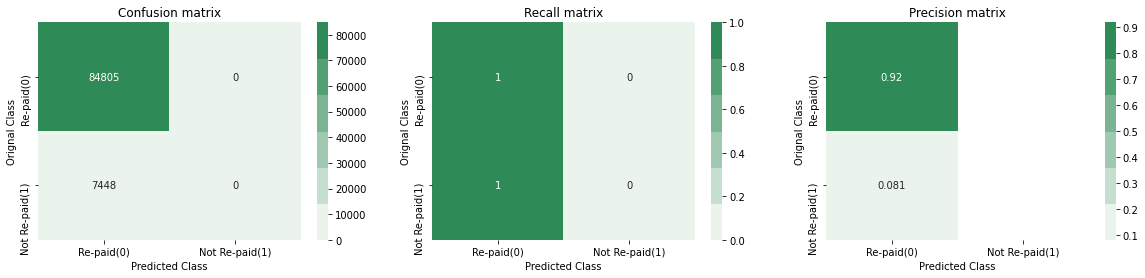

In [45]:
params = {
    'alpha' : 1.0,
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 123,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
clf.fit(X_train[selected_features], y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train[selected_features], y_train)
predicted_proba_test = sig_clf.predict_proba(X_test[selected_features])[:,1]
predict_test = sig_clf.predict(X_test[selected_features])


print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_test, predicted_proba_test)}")
print(f"\tPrecision Score = {precision_score(y_test, predict_test)}")
print(f"\tRecall Score = {recall_score(y_test, predict_test)}")
print(f"\tF1_Score  = {f1_score(y_test, predict_test)}")
plot_confusion_matrix(y_test, predict_test)



<strong> <font color ='red'> RANDOM FOREST CLASSIFIER </font> </strong>

<pre>
https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d

Bagging = Bootstrap Aggregation.
Bootstrap means generating random samples from the dataset with the replacement.
Bagging reduces variance in individual models of ensemble.

</pre>

| Voting Classifier                                                                         | Bagging |
| :---                                                                           |    :----:   |
| Many algorithms (Ex. Decision Tree, LOGIT, KNN)                                | Only one algorithm (Ex. Decison Tree with                                                                                      one set of parameter)       |
| Same training datset used by all algorithm for training their respective models| Different subsets of data used by same                                                                                           algorithm        |



| Bagging                                                                         | RANDOM_FOREST |
| :---                                                                           |    :----:   |
| All features are trained                               | A limited number of features are sampled in each node without                                                                   replacement       |
| Base Estimator can be anything (Ex. Decision Tree, LOGIT, KNN)| Base Estimator is only Decision Tree+        |

In [51]:

params = {
'criterion' : 'gini',
 'class_weight': 'balanced',
 'random_state': 123, 
 'n_jobs' :-1
}
clf = RandomForestClassifier(**params)
hyperparams = {
      'n_estimators' : [200,500,1000,2000],
      'max_depth' : [7, 10]
      }

rscv = RandomizedSearchCV(estimator = clf, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                          cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv.fit(X_train[selected_features], y_train)

# to see Best Parameter selection
print(rscv.best_params_ )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 295.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 361.4min finished


{'n_estimators': 1000, 'max_depth': 10}


Test Dataset Results:
	ROC-AUC Score = 0.7502946356179093
	Precision Score = 0.5384615384615384
	Recall Score = 0.002819548872180451
	F1_Score  = 0.005609723520769333


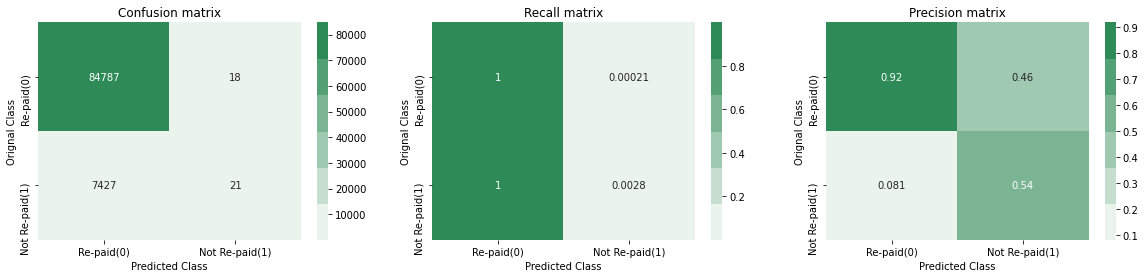

In [24]:
params = {
'n_estimators' : 1000,
'max_depth' : 10,
'criterion' : 'gini',
 'class_weight': 'balanced',
 'random_state': 123, 
 'n_jobs' :-1
}
clf = RandomForestClassifier(**params)
clf.fit(X_train[selected_features], y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train[selected_features], y_train)
predicted_proba_test = sig_clf.predict_proba(X_test[selected_features])[:,1]
predict_test = sig_clf.predict(X_test[selected_features])


print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_test, predicted_proba_test)}")
print(f"\tPrecision Score = {precision_score(y_test, predict_test)}")
print(f"\tRecall Score = {recall_score(y_test, predict_test)}")
print(f"\tF1_Score  = {f1_score(y_test, predict_test)}")
plot_confusion_matrix(y_test, predict_test)

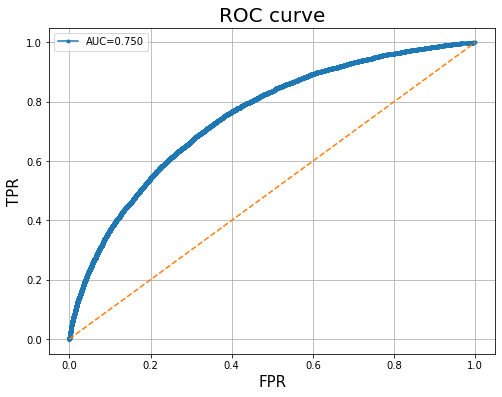

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_proba_test)
auc = roc_auc_score(y_test, predicted_proba_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [28]:
# Actual test score
predict_test_actual = sig_clf.predict(df_main_test[selected_features])

In [43]:
test_result_submit  = pd.DataFrame(data = {'SK_ID_CURR' :df_main_test['SK_ID_CURR'].values, 
                     'TARGET' : predict_test_actual})
test_result_submit.to_csv('test_result_submit.csv',index=False)

## <font color='red'> LightGBM </font> 


Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

In [49]:
weight = np.ones((len(X_train),), dtype=int)
for i in range(len(X_train)):
    if int(y_train.iloc[i])== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train[selected_features], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_test[selected_features], label = y_test)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:
    
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_test[selected_features])
cv_auc_score.append(roc_auc_score(y_test,y_pred_prob))
print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_test,y_pred_prob)))
print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
params = {'boosting_type': 'gbdt',
          'max_depth' : max_depth[np.argmax(cv_auc_score)],
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_train[selected_features])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                  roc_auc_score(y_train,y_pred_prob) ))    

y_pred_prob = lgbm.predict(X_test[selected_features])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                 roc_auc_score(y_test,y_pred_prob) ))
y_pred = np.ones((len(X_test),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.733703
[20]	valid_0's auc: 0.741449
[30]	valid_0's auc: 0.748672
[40]	valid_0's auc: 0.754955
[50]	valid_0's auc: 0.760394
[60]	valid_0's auc: 0.764794
[70]	valid_0's auc: 0.767564
[80]	valid_0's auc: 0.769911
[90]	valid_0's auc: 0.771828
[100]	valid_0's auc: 0.77314
[110]	valid_0's auc: 0.774397
[120]	valid_0's auc: 0.775598
[130]	valid_0's auc: 0.776523
[140]	valid_0's auc: 0.777198
[150]	valid_0's auc: 0.777744
[160]	valid_0's auc: 0.778299
[170]	valid_0's auc: 0.778935
[180]	valid_0's auc: 0.779481
[190]	valid_0's auc: 0.779889
[200]	valid_0's auc: 0.780359
[210]	valid_0's auc: 0.7805
[220]	valid_0's auc: 0.78091
[230]	valid_0's auc: 0.781122
[240]	valid_0's auc: 0.781097
[250]	valid_0's auc: 0.781219
[260]	valid_0's auc: 0.781345
[270]	valid_0's auc: 0.78138
[280]	valid_0's auc: 0.781445
[290]	valid_0's auc: 0.781478
[300]	valid_0's auc: 0.781686
[310]	valid_0's auc: 0.781806
[320]	valid_0's auc: 

Test Dataset Results:
	ROC-AUC Score = 0.7836992314015897
	Precision Score = 0.19008015654988145
	Recall Score = 0.6781686358754028
	F1_Score  = 0.296934246494812


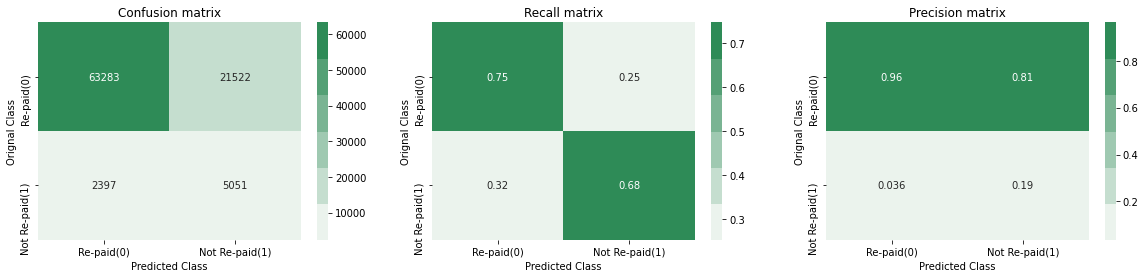

In [55]:
print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_test, y_pred_prob)}")
print(f"\tPrecision Score = {precision_score(y_test, y_pred)}")
print(f"\tRecall Score = {recall_score(y_test, y_pred)}")
print(f"\tF1_Score  = {f1_score(y_test, y_pred)}")
plot_confusion_matrix(y_test, y_pred)

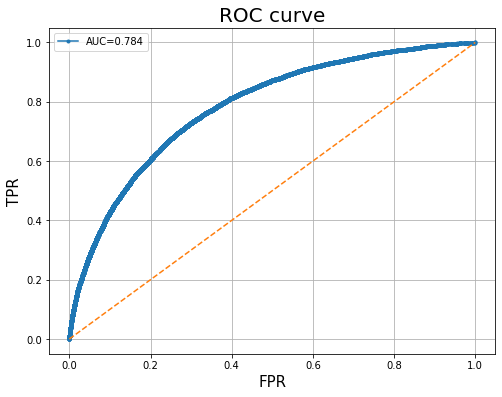

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [52]:
# Actual test score
predict_test_actual = lgbm.predict(df_main_test[selected_features])
test_result_submit  = pd.DataFrame(data = {'SK_ID_CURR' :df_main_test['SK_ID_CURR'].values, 
                     'TARGET' : predict_test_actual})
test_result_submit.to_csv('test_result_submit_lgm.csv',index=False)

In [60]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model",'AUC','Recall','Precision','F1_score', 'Kaggle_score_public', 'Kaggle_score_private']
x.add_row(['Random_model','0.49','0.49','0.08','0.13','Null','Null'])
x.add_row(['Domaiant_Class','0.5','0','0','0','Null','Null'])
x.add_row(['SGD_Classifier','0.5','0','0','0','Null','Null'])
x.add_row(['Random_Forest_Classifier ','0.75','0.5','0.02','0.005','0.5','0.5'])
x.add_row(['LightGBM ','0.78','0.6','0.1','0.19','0.771','0.774'])

print(x)

+---------------------------+------+--------+-----------+----------+---------------------+----------------------+
|           Model           | AUC  | Recall | Precision | F1_score | Kaggle_score_public | Kaggle_score_private |
+---------------------------+------+--------+-----------+----------+---------------------+----------------------+
|        Random_model       | 0.49 |  0.49  |    0.08   |   0.13   |         Null        |         Null         |
|       Domaiant_Class      | 0.5  |   0    |     0     |    0     |         Null        |         Null         |
|       SGD_Classifier      | 0.5  |   0    |     0     |    0     |         Null        |         Null         |
| Random_Forest_Classifier  | 0.75 |  0.5   |    0.02   |  0.005   |         0.5         |         0.5          |
|         LightGBM          | 0.78 |  0.6   |    0.1    |   0.19   |        0.771        |        0.774         |
+---------------------------+------+--------+-----------+----------+--------------------

LightGBM gives the best performance

In [ ]:
# Saving the final model LightGBM as pickle file for the future use in productionizing the model
with open('final_model.pkl','wb') as fp:
    pickle.dump(lgbm, fp)

# KAGGLE RESULTS

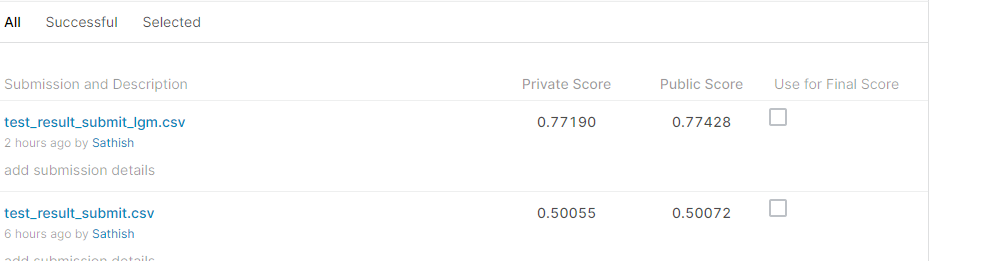